In [1]:
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import os

In [3]:

class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.enc = base_encoder(pretrained=False)  # load model from torchvision.models without pretrained weights.
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))
        
    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return feature, projection



In [7]:
device = torch.device('cuda:0')

network = SimCLR(models.resnet18, 2).to(device)
print(network)

SimCLR(
  (enc): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): 

In [50]:
network.load_state_dict(torch.load(os.path.join('../trained_backbones/')))

torch.Size([128, 64])

In [8]:
cifar10 =np.load(os.path.join('../../extracted_features',
                              'proj_dim_2_simclr_temperature_0.5_bs_1024',
                              'Features_from_layer_11_cifar10_mean_test_ind.npy'))

In [18]:
cifar10_norm = cifar10 / np.linalg.norm(cifar10,axis=1).reshape(10000,1)

In [36]:
cifar10_angle = np.arctan2(cifar10_norm[:,0],cifar10_norm[:,1])

<AxesSubplot:ylabel='Count'>

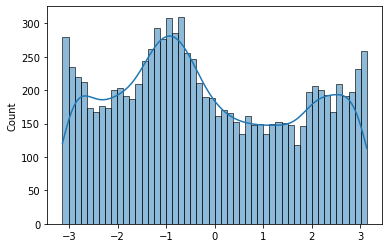

In [41]:
import seaborn as sns
sns.histplot(cifar10_angle,bins=50,kde=True)

In [19]:
np.linalg.norm(cifar10,axis=1)

array([ 824.80176, 1404.1583 , 1365.4104 , ..., 1200.3729 ,  505.85623,
       1297.0118 ], dtype=float32)

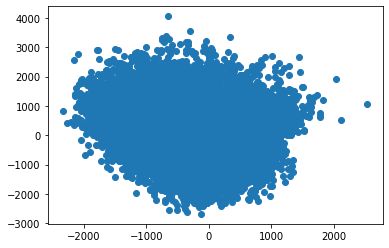

In [20]:
import matplotlib.pyplot as plt
plt.scatter(cifar10[:,0],cifar10[:,1])

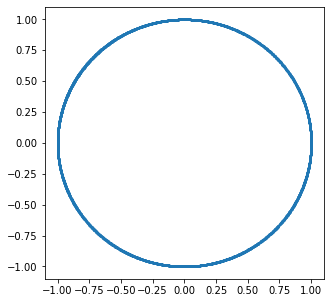

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(cifar10_norm[:,0],cifar10_norm[:,1],s=1)

In [32]:
svhn =np.load(os.path.join('../../extracted_features',
                              'proj_dim_2_simclr_temperature_0.5_bs_1024',
                              'Features_from_layer_11_svhn_mean_test_ood.npy'))

In [33]:
svhn_norm = svhn / np.linalg.norm(svhn,axis=1).reshape(-1,1)

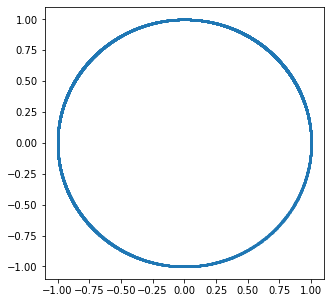

In [34]:
plt.figure(figsize=(5,5))
plt.scatter(svhn_norm[:,0],svhn_norm[:,1],s=1)

In [39]:
svhn_angle = np.arctan2(svhn_norm[:,0],svhn_norm[:,1])

<AxesSubplot:ylabel='Count'>

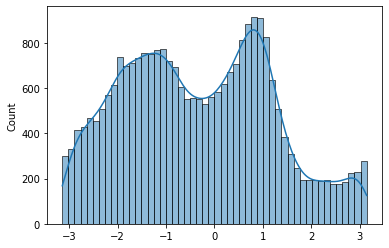

In [42]:
sns.histplot(svhn_angle,bins=50,kde=True)

In [43]:
lsun_fix =np.load(os.path.join('../../extracted_features',
                              'proj_dim_2_simclr_temperature_0.5_bs_1024',
                              'Features_from_layer_11_lsun_fix_mean_test_ood.npy'))

In [46]:
lsun_fix_norm = lsun_fix / np.linalg.norm(lsun_fix,axis=1).reshape(-1,1)
lsun_fix_angle = np.arctan2(lsun_fix_norm[:,0],lsun_fix_norm[:,1])

<AxesSubplot:ylabel='Count'>

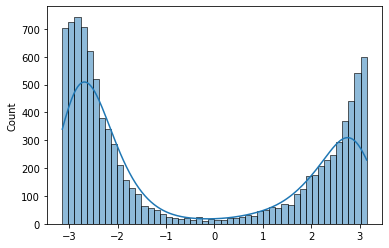

In [47]:
sns.histplot(lsun_fix_angle,bins=50,kde=True)

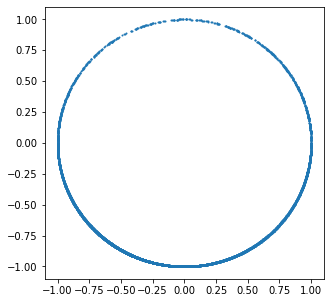

In [67]:
plt.figure(figsize=(5,5))
plt.scatter(lsun_fix_norm[:,0],lsun_fix_norm[:,1],s=1)

In [49]:
lsun_resize =np.load(os.path.join('../../extracted_features',
                              'proj_dim_2_simclr_temperature_0.5_bs_1024',
                              'Features_from_layer_11_lsun_resize_mean_test_ood.npy'))

In [50]:
lsun_resize_norm = lsun_resize / np.linalg.norm(lsun_resize,axis=1).reshape(-1,1)
lsun_resize_angle = np.arctan2(lsun_resize_norm[:,0],lsun_resize_norm[:,1])

<AxesSubplot:ylabel='Count'>

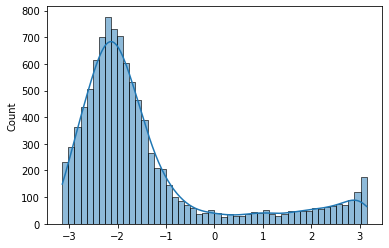

In [51]:
sns.histplot(lsun_resize_angle,bins=50,kde=True)

<AxesSubplot:ylabel='Count'>

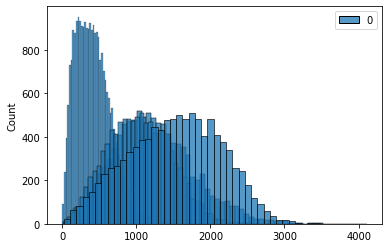

In [66]:
sns.histplot(np.linalg.norm(cifar10,axis=1).reshape(-1,1))
sns.histplot(np.linalg.norm(svhn,axis=1).reshape(-1,1))
sns.histplot(np.linalg.norm(lsun_fix,axis=1).reshape(-1,1))
sns.histplot(np.linalg.norm(lsun_resize,axis=1).reshape(-1,1))

In [68]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))


In [70]:
cifar10 =np.load(os.path.join('../../extracted_features',
                              'sigmoid_proj_dim_2_simclr_temperature_0.5_bs_1024',
                              'Features_from_layer_11_cifar10_mean_test_ind.npy'))

In [73]:
cifar10_sigmoid = sigmoid(cifar10)

/home/sr8/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [76]:
svhn =np.load(os.path.join('../../extracted_features',
                              'sigmoid_proj_dim_2_simclr_temperature_0.5_bs_1024',
                              'Features_from_layer_11_svhn_mean_test_ood.npy'))

In [77]:
svhn_sigmoid = sigmoid(svhn)

In [84]:
lsun_fix =np.load(os.path.join('../../extracted_features',
                              'sigmoid_proj_dim_2_simclr_temperature_0.5_bs_1024',
                              'Features_from_layer_11_lsun_fix_mean_test_ood.npy'))
lsun_fix_sigmoid = sigmoid(lsun_fix)

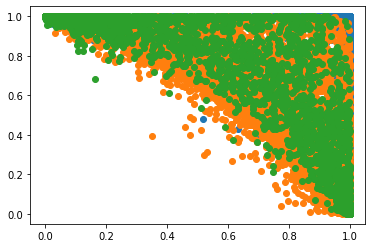

In [85]:
plt.scatter(cifar10_sigmoid[:,0],cifar10_sigmoid[:,1])
plt.scatter(svhn_sigmoid[:,0],svhn_sigmoid[:,1])
plt.scatter(lsun_fix_sigmoid[:,0],lsun_fix_sigmoid[:,1])



array([[5.7756501e-11, 1.0000000e+00],
       [1.2009952e-09, 1.0000000e+00],
       [8.9767404e-02, 9.8989946e-01],
       ...,
       [3.2676579e-07, 1.0000000e+00],
       [8.2785959e-24, 1.0000000e+00],
       [6.7287266e-01, 9.9763143e-01]], dtype=float32)